# DCT image segmentation


In [1]:
# imported libraries
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.fftpack import dct


In [2]:

# load data
Tdata = scipy.io.loadmat('homework1/TrainingSamplesDCT_8.mat')
TrainsampleDCT_FG = Tdata['TrainsampleDCT_FG']
TrainsampleDCT_BG = Tdata['TrainsampleDCT_BG']

print('DCT_FG: ', TrainsampleDCT_FG.shape)
print('DCT_BG: ', TrainsampleDCT_BG.shape)

# load bmp images
cheetah = Image.open('homework1/cheetah.bmp')
cheetah = np.array(cheetah)
cheetah_mask = Image.open('homework1/cheetah_mask.bmp')
cheetah_mask = np.array(cheetah_mask)

print('cheetah image shape: ', cheetah.shape)
print('cheetah mask shape: ', cheetah_mask.shape)

# sig-zag pattern
sig_pattern = [
    [0, 1, 5, 6, 14, 15, 27, 28],
    [2, 4, 7, 13, 16, 26, 29, 42],
    [3, 8, 12, 17, 25, 30, 41, 43],
    [9, 11, 18, 24, 31, 40, 44, 53],
    [10, 19, 23, 32, 39, 45, 52, 54],
    [20, 22, 33, 38, 46, 51, 55, 60],
    [21, 34, 37, 47, 50, 56, 59, 61],
    [35, 36, 48, 49, 57, 58, 62, 63]
]

DCT_FG:  (250, 64)
DCT_BG:  (1053, 64)
cheetah image shape:  (255, 270)
cheetah mask shape:  (255, 270)



a) Using the training data in TrainingSamplesDCT 8.mat, what are reasonable estimates for the prior
probabilities?

- P(cheetah) = number of forground samples / number of total samples
- P(grass) = number of background samples / number of total samples = 1-P(cheetah)

In [3]:
# Calculate the prior probabilities of cheetah and grass
Pcheetah = TrainsampleDCT_FG.shape[0] / (TrainsampleDCT_FG.shape[0] + TrainsampleDCT_BG.shape[0])
Pgrass = 1-Pcheetah 

# Print the prior probabilities
print('P(cheetah) = ', Pcheetah)
print('P(grass) = ', Pgrass)

P(cheetah) =  0.1918649270913277
P(grass) =  0.8081350729086723



b) using the training data in TrainingSamplesDCT 8.mat, compute and plot the index histograms
PX|Y (x|cheetah) and PX|Y (x|grass).


In [4]:
# find the index of the second highest value in each row
indexFG = [np.argsort(np.abs(row))[-2] for row in TrainsampleDCT_FG]
indexBG = [np.argsort(np.abs(row))[-2] for row in TrainsampleDCT_BG]

# Create histograms of the indices for both foreground and background data
indexFG_hist = 64*[0]
for i in indexFG:
    indexFG_hist[i] += 1

indexBG_hist = 64*[0]
for i in indexBG:
    indexBG_hist[i] += 1

# Normalize the histograms to obtain the probability distribution of the indices for each class
indexFG_P_hist = [x/sum(indexFG_hist) for x in indexFG_hist]
indexBG_P_hist = [x/sum(indexBG_hist) for x in indexBG_hist]

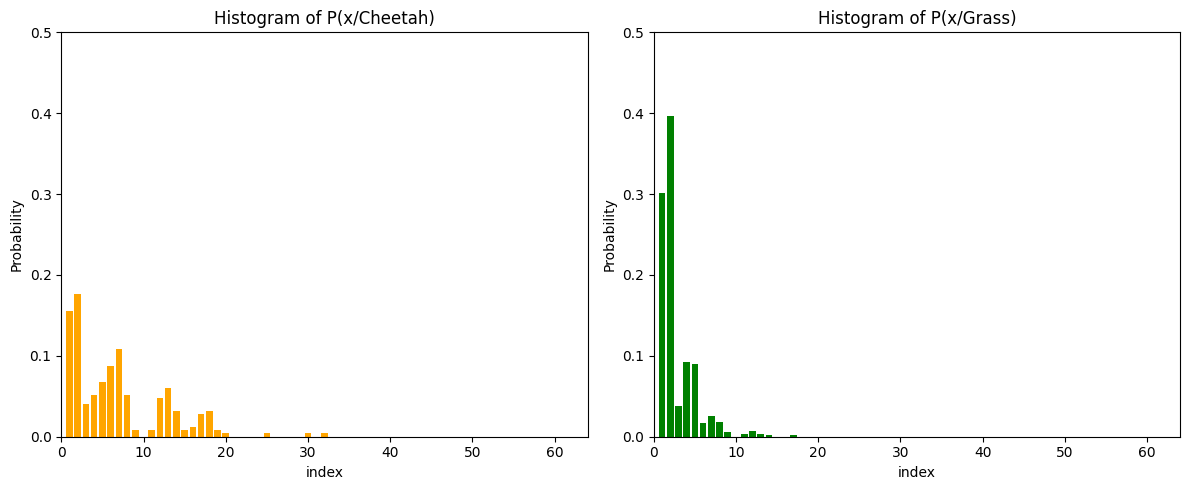

[0.0, 0.156, 0.176, 0.04, 0.052, 0.068, 0.088, 0.108, 0.052, 0.008, 0.0, 0.008, 0.048, 0.06, 0.032, 0.008, 0.012, 0.028, 0.032, 0.008, 0.004, 0.0, 0.0, 0.0, 0.0, 0.004, 0.0, 0.0, 0.0, 0.0, 0.004, 0.0, 0.004, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [9]:

# Plot the histogram of the energy values
bins = 64
# Create the histogram of probabilities for cheetah
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].bar(range(bins), indexFG_P_hist, color='orange')
axes[0].set_title('Histogram of P(x/Cheetah)')

# Create the histogram for grass
axes[1].bar(range(bins), indexBG_P_hist, color='green')
axes[1].set_title('Histogram of P(x/Grass)')

# Ensure the same bin size and value range for both histograms
for ax in axes:
    ax.set_xlabel('index')
    ax.set_ylabel('Probability')
    ax.set_xlim([0, bins]) 
    ax.set_ylim([0, 0.5]) 

plt.tight_layout()
plt.show()
print(indexFG_P_hist)

Calculate a list that shows the outcome for each index ie 1 if the most probable for that index is a cheetah and 0 if it is grass 

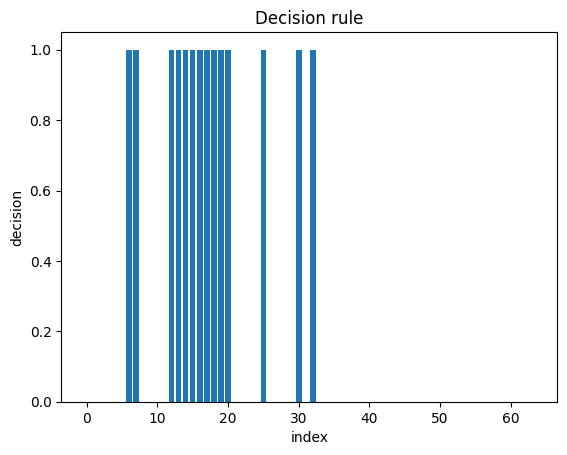

In [6]:
# Decision array

# calculate the probability of each index being found ie P(X)
Px = 64*[0]
for i in range(64):
    if indexFG_hist[i] + indexBG_hist[i] != 0:
        Px[i] = indexFG_hist[i]/(indexFG_hist[i]+indexBG_hist[i])

# calculate P(Cheetah|X) & P(Grass|X) for each index and flag the greater one in dec array
dec = 64*[0]
for i in range(64):
    if Px[i] !=0:

        # P(Grass|X) = P(X|Grass)*P(Grass)/P(X)
        vg = indexBG_P_hist[i]*Pgrass/Px[i] 
        # P(Cheetah|X) = P(X|Cheetah)*P(Cheetah)/P(X)
        vc = indexFG_P_hist[i]*Pcheetah/Px[i]
        
        # store the resultant decision
        if vg > vc:
            dec[i] = 0
        else:
            dec[i] = 1

# plot the decision array
plt.bar(range(64), dec)
plt.title('Decision rule')
plt.xlabel('index')
plt.ylabel('decision')
plt.show()


c) for each block in the image cheetah.bmp, compute the feature X (index of the DCT coefficient with
2nd greatest energy). Compute the state variable Y using the minimum probability of error rule based
on the probabilities obtained in a) and b). Store the state in an array A. Using the commands imagesc
and colormap(gray(255)) create a picture of that array.


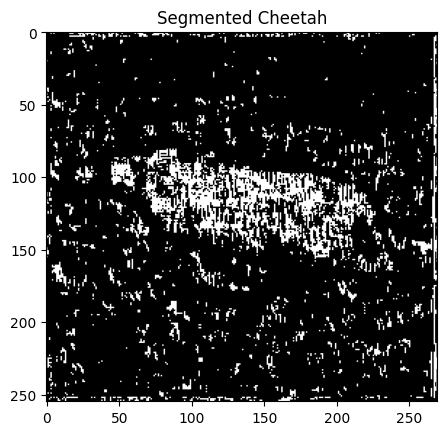

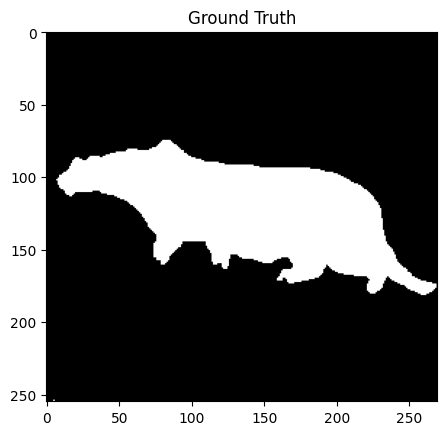

In [7]:
# Set the size of the grid to 8x8
grid_size = 8

# Set the padding size to 4
padding = 4

# Get the dimensions of the image
height, width = cheetah.shape

# Calculate the new dimensions for the padded image
padded_height = height + 2 * padding
padded_width = width + 2 * padding

# Create a new image to hold the padded image
result_img = np.random.randint(0, 256, size=(height + 2 * padding, width + 2 * padding), dtype=np.uint8)

# Copy the original image into the padded image
result_img[padding:padding+height, padding:padding+width] = cheetah

# Create an empty array to hold the segmented cheetah
segmented_cheetah = np.zeros((height, width), dtype=np.uint8)

# Define a function to calculate the outcome for a given 8x8 grid
def outcome(grid):
    # Initialize an array to hold the DCT coefficients
    dc = 64*[0]
    
    # Calculate the DCT of the grid
    dct_result = dct(dct(grid, axis=0, norm='ortho'), axis=1, norm='ortho')
    
    # Reorder the DCT coefficients using the zigzag pattern
    for row in range(8):
        for e in range(8):
            dc[sig_pattern[row][e]] = dct_result[row][e]
    
    # Find the index of the DCT coefficient with the second highest energy
    a = np.argsort(np.abs(dc))[-2]
    
    # Return the decision for that index
    return dec[a]

# Loop over each pixel in the image
for row in range(height):
    for col in range(width):
        
        # Extract the 8x8 grid centered at the current pixel
        grid = result_img[row:row +grid_size, col:col + grid_size]
       
        # Calculate the decision for the grid
        scalar_value = outcome(grid)

        # Store the decision in the segmented cheetah array
        segmented_cheetah[row, col] = scalar_value

# Display the segmented cheetah and the ground truth
plt.imshow(segmented_cheetah, cmap='gray')
plt.title('Segmented Cheetah')
plt.show()
plt.imshow(cheetah_mask, cmap='gray')
plt.title('Ground Truth')
plt.show()



d) The array A contains a mask that indicates which blocks contain grass and which contain the
cheetah. Compare it with the ground truth provided in image cheetah mask.bmp (shown below on the
right) and compute the probability of error of your algorithm.


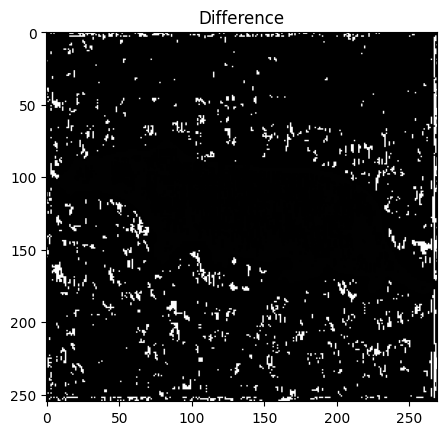

MSE:  0.18470588235294116


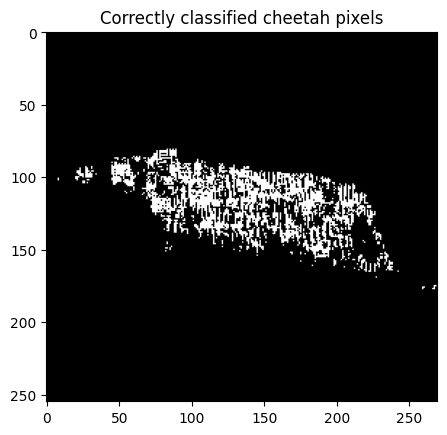

In [8]:
# calculate the difference between the segmented cheetah and the ground truth
diff = np.abs(segmented_cheetah*255 - cheetah_mask)

# show the difference between the segmented cheetah and the ground truth
plt.imshow(diff, cmap='gray')
plt.title('Difference')
plt.show()

# calculating the mean squared error
mse = np.mean(diff**2)
print('MSE: ', mse)

# show the correctly classified cheetah pixels
known = segmented_cheetah + cheetah_mask/255
known[known!=2] = 0
known[known==2] = 1
plt.imshow(known, cmap='gray')
plt.title('Correctly classified cheetah pixels')
plt.show()